In [1]:
# !pip install -U -q transformers

In [2]:
# if error in BERT model init do
# !pip uninstall -y transformers accelerate
!pip install transformers accelerate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 47.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 219.1/219.1 kB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 76.0 MB/s eta 0:00:00


In [3]:
!pip show transformers

Name: transformers
Version: 4.29.2
Summary: State-of-the-art Machine Learning for JAX, PyTorch and TensorFlow
Home-page: https://github.com/huggingface/transformers
Author: The Hugging Face team (past and future) with the help of all our contributors (https://github.com/huggingface/transformers/graphs/contributors)
Author-email: transformers@huggingface.co
License: Apache 2.0 License
Location: /usr/local/lib/python3.10/dist-packages
Requires: filelock, huggingface-hub, numpy, packaging, pyyaml, regex, requests, tokenizers, tqdm
Required-by: 


In [4]:
!curl -X GET https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Video_Games_v1_00.tsv.gz -o video_games.tsv.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  453M  100  453M    0     0  62.5M      0  0:00:07  0:00:07 --:--:-- 74.3M


In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report
from sklearn.metrics import mean_squared_error
import torch
import transformers
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [7]:
# read data into pandas dataframe
path = "video_games.tsv.gz"
video_games = pd.read_csv(path, sep="\t", verbose=True, parse_dates=[14], on_bad_lines="skip")

Tokenization took: 513.34 ms
Type conversion took: 303.68 ms
Parser memory cleanup took: 0.01 ms
Tokenization took: 543.42 ms
Type conversion took: 268.85 ms
Parser memory cleanup took: 0.01 ms
Tokenization took: 610.36 ms
Type conversion took: 301.99 ms
Parser memory cleanup took: 0.01 ms
Tokenization took: 423.50 ms
Type conversion took: 338.87 ms
Parser memory cleanup took: 0.01 ms
Tokenization took: 372.76 ms
Type conversion took: 253.38 ms
Parser memory cleanup took: 0.01 ms
Tokenization took: 455.91 ms
Type conversion took: 400.66 ms
Parser memory cleanup took: 0.01 ms
Tokenization took: 550.66 ms
Type conversion took: 424.02 ms
Parser memory cleanup took: 0.01 ms
Tokenization took: 969.58 ms
Type conversion took: 377.88 ms
Parser memory cleanup took: 0.01 ms
Tokenization took: 673.95 ms
Type conversion took: 614.91 ms
Parser memory cleanup took: 0.01 ms
Tokenization took: 1223.74 ms
Type conversion took: 750.42 ms
Parser memory cleanup took: 0.01 ms
Tokenization took: 1015.20 ms

In [8]:
video_games.head()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,12039526,RTIS3L2M1F5SM,B001CXYMFS,737716809,Thrustmaster T-Flight Hotas X Flight Stick,Video Games,5,0,0,N,Y,an amazing joystick. I especially love that yo...,"Used this for Elite Dangerous on my mac, an am...",2015-08-31
1,US,9636577,R1ZV7R40OLHKD,B00M920ND6,569686175,Tonsee 6 buttons Wireless Optical Silent Gamin...,Video Games,5,0,0,N,Y,Definitely a silent mouse... Not a single clic...,"Loved it, I didn't even realise it was a gami...",2015-08-31
2,US,2331478,R3BH071QLH8QMC,B0029CSOD2,98937668,Hidden Mysteries: Titanic Secrets of the Fatef...,Video Games,1,0,1,N,Y,One Star,poor quality work and not as it is advertised.,2015-08-31
3,US,52495923,R127K9NTSXA2YH,B00GOOSV98,23143350,GelTabz Performance Thumb Grips - PlayStation ...,Video Games,3,0,0,N,Y,"good, but could be bettee","nice, but tend to slip away from stick in inte...",2015-08-31
4,US,14533949,R32ZWUXDJPW27Q,B00Y074JOM,821342511,Zero Suit Samus amiibo - Japan Import (Super S...,Video Games,4,0,0,N,Y,Great but flawed.,"Great amiibo, great for collecting. Quality ma...",2015-08-31


In [9]:
# filter by last two years based on review_date
from datetime import datetime

video_games['review_date'] = pd.to_datetime(video_games['review_date'])
video_games = video_games[video_games['review_date'] >= datetime(2015, 1, 1)] # 8 months - maybe we need a full year? If so, we need to sample stratified from 2014-8-31

In [10]:
video_games.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 330966 entries, 0 to 330970
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   marketplace        330966 non-null  object        
 1   customer_id        330966 non-null  int64         
 2   review_id          330966 non-null  object        
 3   product_id         330966 non-null  object        
 4   product_parent     330966 non-null  int64         
 5   product_title      330966 non-null  object        
 6   product_category   330966 non-null  object        
 7   star_rating        330966 non-null  int64         
 8   helpful_votes      330966 non-null  int64         
 9   total_votes        330966 non-null  int64         
 10  vine               330966 non-null  object        
 11  verified_purchase  330966 non-null  object        
 12  review_headline    330966 non-null  object        
 13  review_body        330917 non-null  object  

In [11]:
video_games = video_games[["review_headline", "review_body", "star_rating"]]

video_games.head()

,review_headline,review_body,star_rating
0,an amazing joystick. I especially love that yo...,"Used this for Elite Dangerous on my mac, an am...",5
1,Definitely a silent mouse... Not a single clic...,"Loved it, I didn't even realise it was a gami...",5
2,One Star,poor quality work and not as it is advertised.,1
3,"good, but could be bettee","nice, but tend to slip away from stick in inte...",3
4,Great but flawed.,"Great amiibo, great for collecting. Quality ma...",4


In [12]:
# concat headline and review body
video_games['full_review'] = video_games['review_headline'] + ' ' + video_games['review_body']
video_games.head()

,review_headline,review_body,star_rating,full_review
0,an amazing joystick. I especially love that yo...,"Used this for Elite Dangerous on my mac, an am...",5,an amazing joystick. I especially love that yo...
1,Definitely a silent mouse... Not a single clic...,"Loved it, I didn't even realise it was a gami...",5,Definitely a silent mouse... Not a single clic...
2,One Star,poor quality work and not as it is advertised.,1,One Star poor quality work and not as it is ad...
3,"good, but could be bettee","nice, but tend to slip away from stick in inte...",3,"good, but could be bettee nice, but tend to sl..."
4,Great but flawed.,"Great amiibo, great for collecting. Quality ma...",4,"Great but flawed. Great amiibo, great for coll..."


In [13]:
video_games = video_games[['full_review', 'star_rating']]
video_games.head()

,full_review,star_rating
0,an amazing joystick. I especially love that yo...,5
1,Definitely a silent mouse... Not a single clic...,5
2,One Star poor quality work and not as it is ad...,1
3,"good, but could be bettee nice, but tend to sl...",3
4,"Great but flawed. Great amiibo, great for coll...",4


# Stratified Sampling

In [14]:
from sklearn.model_selection import StratifiedShuffleSplit

In [15]:
from sklearn.model_selection import StratifiedShuffleSplit

# Assuming you have a DataFrame called 'full_dataset' with the complete dataset

# Define the desired sampling size
sample_size = 30000  # Number of records to sample

# Specify the column to use for stratification
stratify_column = 'star_rating'  # Replace with the actual column name

# Create a StratifiedShuffleSplit object
stratified_split = StratifiedShuffleSplit(n_splits=1, test_size=sample_size, random_state=42)

# Generate the indices for stratified sampling
indices = stratified_split.split(video_games, video_games[stratify_column])

# Extract the indices for the sampled records
sampled_indices = next(indices)[1]

# Create the sampled DataFrame based on the indices
video_games = video_games.iloc[sampled_indices].reset_index(drop=False)


In [16]:
video_games.head()

,index,full_review,star_rating
0,145452,"This is my favorite game, ever This is my favo...",5
1,295636,Five Stars Everything went smooth sailing! :),5
2,207743,This is a wonderful alternative to the officia...,5
3,79712,Five Stars VERY GOOD GAME TO PLAY,5
4,243959,Five Stars excellent,5


# Train- Test-Split

In [17]:
# create train, validation and test splits
train_df, test_df = train_test_split(video_games, test_size=0.3)
train_df, val_df = train_test_split(train_df, test_size=0.3)

print(len(train_df))
print(len(val_df))
print(len(test_df))

14700
6300
9000


In [18]:
train_df.head()

,index,full_review,star_rating
12251,246673,"Four Stars If you like hidden object games, yo...",4
12645,282325,Five Stars Excellent product,5
24188,203546,graet game obviously the best game for vita<br...,5
23184,158748,About as much fun now as Zelda was when I was ...,4
9072,259950,"Good, but have problems with xbox party chat I...",3


In [19]:
val_df.head()

,index,full_review,star_rating
20645,40106,Waste of time and money The item I received is...,1
11941,235205,Five Stars nice,5
5497,122652,It just works. I needed a replacement. This is...,5
11263,163053,Super Cool! Fantastic because these aluminium ...,5
12915,51656,love it love it,5


In [20]:
test_df.head()

,index,full_review,star_rating
19156,312856,good Won't work in my Windows but that was my ...,3
6503,50005,"Excellent, The Item and the Delivered Excellen...",5
8333,134602,Very handy if you are into flight sims or raci...,5
25808,62686,Five Stars Great game!,5
12503,183569,"Four Stars Great game, and lots of fun.",4


In [21]:
# prepare input as list instances
X_train = train_df['full_review'].tolist()
y_train = np.array(train_df['star_rating']) -1 # need to substract 1 since BERT expects labels starting from 0

X_val = val_df['full_review'].tolist()
y_val = np.array(val_df['star_rating']) - 1

X_test = test_df['full_review'].tolist()
y_test = np.array(test_df['star_rating']) - 1

In [22]:
print(y_train)

[3 4 4 ... 2 4 0]


# Tokenization

In [23]:
from transformers import BertTokenizer

In [24]:
import random
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)

In [25]:
# Specify the pre-trained model name.
PRE_TRAINED_MODEL_NAME = 'bert-base-uncased' # uncased means this tokenizer will also lower-case automatically

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

Loading BERT tokenizer...


In [26]:
# # Encode the preprocessed text by using encode_plus function
# train_encoded = tokenizer.encode_plus(
#                           text=X_train,
#                           add_special_tokens = True, # Add '[CLS]' and '[SEP]' and [PAD]
#                           max_length=256,      # Pad & truncate all texts
#                           truncation=True,
#                           padding='max_length',
#                           return_token_type_ids=False,
#                           return_attention_mask = True, # Construct attention masks
#                           return_tensors = 'pt', # Return pytorch tensors
#                     )
# print('input_ids: {}\n'.format(train_encoded['input_ids']))
# print('attention_mask: {}\n'.format(train_encoded['attention_mask']))

In [27]:
# print(tokenizer.convert_ids_to_tokens(train_encoded['input_ids'][0]))

In [28]:
# We need the class of type Dataset for input in the Trainer function
# we can write a class: with the input texts, labels, tokenizer and max_len
# we'll have the full_review, input_ids, attention_mask, labels as our output
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

class AmazonReviewDataset(Dataset):

    def __init__(self, full_review, labels, tokenizer, max_len):
        self.full_review = full_review
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.full_review)

    def __getitem__(self, item):
        full_review = str(self.full_review[item])
        label = self.labels[item]
        # `encode_plus` will:
          #   (1) Tokenize the text.
          #   (2) Prepend the `[CLS]` token to the start.
          #   (3) Append the `[SEP]` token to the end.
          #   (4) Map tokens to their IDs.
          #   (5) Pad or truncate the sentence to `max_length` with [PAD] tokens
          #   (6) Create attention masks for [PAD] tokens
        encoding = self.tokenizer.encode_plus(
          full_review,
          add_special_tokens=True, # Add '[CLS]' and '[SEP]' and [PAD]
          max_length=self.max_len, # Pad & truncate all texts
          truncation=True,
          padding='max_length',
          return_token_type_ids=False,
          return_attention_mask=True, # Construct attention masks
          return_tensors='pt', # Return pytorch tensors
        )

        return {
          'news_text': full_review,
          'input_ids': encoding['input_ids'].flatten(),
          'attention_mask': encoding['attention_mask'].flatten(),
          'labels': torch.tensor(label, dtype=torch.long)
        }

# Training

In [29]:
from transformers import TrainingArguments, Trainer, BertForSequenceClassification, BertConfig

from sklearn.metrics import accuracy_score

training_args = TrainingArguments(output_dir="test_trainer", evaluation_strategy="epoch", num_train_epochs=1)
max_len = 256

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {'accuracy': accuracy_score(labels, predictions)}

model = BertForSequenceClassification.from_pretrained(
    PRE_TRAINED_MODEL_NAME, # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 5, # The number of output labels, in our case it's multi-class tasks with classes=4  
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=AmazonReviewDataset(full_review=np.array(X_train), labels=np.array(y_train), tokenizer=tokenizer, max_len=max_len),
    eval_dataset=AmazonReviewDataset(full_review=np.array(X_val), labels=np.array(y_val), tokenizer=tokenizer, max_len=max_len),
    compute_metrics=compute_metrics
)

# training, evaluation and prediction loops can be done with one simple line of code:
trainer.train()
trainer.evaluate()
pred_tuple = trainer.predict(AmazonReviewDataset(full_review=np.array(X_test), labels=np.array(y_test), tokenizer=tokenizer, max_len=max_len))

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Epoch,Training Loss,Validation Loss,Accuracy
1,0.421800,0.396070,0.858730


# Fine-Tuning

In [30]:
from torch.optim import AdamW

In [31]:
# Then we use DataLoader class from pytorch https://pytorch.org/docs/stable/data.html
# which help us to customizing data loading order and do automatic batching
def create_data_loader(X, Y, tokenizer, max_len, batch_size, num_workers=2, sampler = None):
    ds = AmazonReviewDataset(
    full_review=np.array(X),
    labels=np.array(Y),
    tokenizer=tokenizer,
    max_len=max_len
  )
    if sampler != None:
        sampler = sampler(ds)

    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=num_workers,
        sampler = sampler
  )

In [32]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
MAX_LEN = 256
BATCH_SIZE = 16

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order.
train_data_loader = create_data_loader(X_train, y_train, tokenizer, MAX_LEN, BATCH_SIZE, sampler = RandomSampler) # Select batches randomly

# For validation & testing samples, the order doesn't matter, so we'll just read them sequentially.
val_data_loader = create_data_loader(X_val, y_val, tokenizer, MAX_LEN, BATCH_SIZE, sampler = SequentialSampler) # Pull out batches sequentially.

test_data_loader = create_data_loader(X_test, y_test, tokenizer, MAX_LEN, BATCH_SIZE, sampler = SequentialSampler) # Pull out batches sequentially.

In [33]:
# More optimizers to look up: https://pytorch.org/docs/stable/optim.html
optimizer = AdamW(model.parameters(),
                  lr = 1e-6, # args.learning_rate - default is 1e-3
                )

In [34]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4 (depend on the usage, you can also set it larger)
# We chose to run for 1 epoch first
EPOCHS = 1

# Total number of training steps is [number of batches] x [number of epochs]. 
total_steps = len(train_data_loader) * EPOCHS

# Create the learning rate scheduler, here we use a linear scheduler with no warmup steps
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

# Define our loss function
loss_fn = nn.CrossEntropyLoss().to(device)

In [35]:
# Training
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model.train()
    total_train_accuracy = 0
    total_train_loss = 0
    losses = []
    correct_predictions = 0
    for step, batch in enumerate(data_loader):
        if step % 40 == 0 and not step == 0:
            print('Batch: {}  of  {}'.format(step, len(data_loader)))
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)
        model.zero_grad()
        outputs = model(
          input_ids=input_ids,
          token_type_ids=None,
          attention_mask=attention_mask,
          labels=labels
        )
        loss = outputs[0]
        total_train_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

        logits = outputs[1].detach().cpu().numpy()
        label_ids = labels.to('cpu').numpy()
        total_train_accuracy += flat_accuracy(logits, label_ids)
  # Calculate the average loss over all of the batches.
    avg_train_accuracy = total_train_accuracy / len(data_loader)
    avg_train_loss = total_train_loss / len(data_loader) 
    return avg_train_accuracy, avg_train_loss

In [36]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [43]:
# Evaluation
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model.eval()
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0
    losses = []
    correct_predictions = 0
    predictions = []
    actual_labels = []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)
            outputs = model(
            input_ids=input_ids,
            token_type_ids=None,
            attention_mask=attention_mask,
            labels=labels
            )
            total_eval_loss += outputs[0].item()
            logits = outputs[1].detach().cpu().numpy()
            label_ids = labels.to('cpu').numpy()
            total_eval_accuracy += flat_accuracy(logits, label_ids)

            # Store predictions and actual labels
            predicted_labels = np.argmax(logits, axis=1)
            predictions.extend(predicted_labels.tolist())
            actual_labels.extend(label_ids.tolist())

    avg_val_accuracy = total_eval_accuracy / len(data_loader)
    avg_val_loss = total_eval_loss / len(data_loader)
    #print("Accuracy: {0:.2f}".format(avg_val_accuracy))
    #print("Validation Loss: {0:.2f}".format(avg_val_loss))
    return avg_val_accuracy, avg_val_loss, predictions, actual_labels

In [38]:
%%time
from collections import defaultdict
history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):
    print('Epoch: {}/{}'.format(epoch+1, EPOCHS))
    print('-' * 10)
    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(X_train)
    )
    print('Train loss: {}, Accuracy: {}'.format(train_loss, train_acc))
    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn,
        device,
        len(X_val)
    )
    print('Val loss: {}, Accuracy: {}'.format(val_loss, val_acc))
    print()
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc

Epoch: 1/1
----------
Batch: 40  of  919
Batch: 80  of  919
Batch: 120  of  919
Batch: 160  of  919
Batch: 200  of  919
Batch: 240  of  919
Batch: 280  of  919
Batch: 320  of  919
Batch: 360  of  919
Batch: 400  of  919
Batch: 440  of  919
Batch: 480  of  919
Batch: 520  of  919
Batch: 560  of  919
Batch: 600  of  919
Batch: 640  of  919
Batch: 680  of  919
Batch: 720  of  919
Batch: 760  of  919
Batch: 800  of  919
Batch: 840  of  919
Batch: 880  of  919
Train loss: 0.2908778692422368, Accuracy: 0.8942918026840768
Val loss: 0.392503107292814, Accuracy: 0.8583439086294417

CPU times: user 12min 27s, sys: 3.21 s, total: 12min 30s
Wall time: 12min 47s


In [65]:
test_acc, test_loss, predictions, actual_labels = eval_model(
        model,
        test_data_loader,
        loss_fn,
        device,
        len(X_test)
    )
print('Testing Accuracy: {}'.format(test_acc.item()))

Testing Accuracy: 0.8571269982238011


(0.0, 1.0)

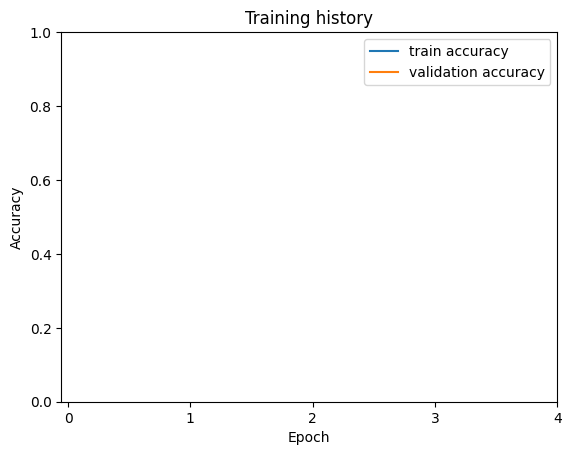

In [40]:
# Plot the accuracy for training and validation set
import matplotlib.pyplot as plt
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.xticks(np.arange(0, 5, 1.0))
plt.ylim([0, 1])

# Inspect sentiment predictions

In [66]:
zipped = list(zip(predictions, actual_labels))

In [70]:
predictions_df = pd.DataFrame(predictions)
actual_df = pd.DataFrame(actual_labels)

In [75]:
X_test = pd.DataFrame(X_test)

In [74]:
type(X_test)

list

In [78]:
combined_df = pd.concat([X_test, predictions_df, actual_df], axis=1, keys=['Full Review', 'Predictions', 'Actual Labels'])

In [82]:
combined_df.columns = ['Full Review', 'Predicted', 'Actual']

In [83]:
combined_df

,Full Review,Predicted,Actual
0,good Won't work in my Windows but that was my ...,4,2
1,"Excellent, The Item and the Delivered Excellen...",4,4
2,Very handy if you are into flight sims or raci...,4,4
3,Five Stars Great game!,4,4
4,"Four Stars Great game, and lots of fun.",3,3
...,...,...,...
8995,Five Stars I love the oldies.,4,4
8996,"Very pleased, surprised even. This thing is am...",4,4
8997,Worth The Purchase A good pad overall. No comp...,4,3
8998,Four Stars Works great and looks great.,3,3


TO-DOs:

 a) run more epochs? plot the accuracy plot for training & validation set

 b) try larger/smaller batch size

 c) different learning rate/optimizers?

 d) what should be the optimal max_len for our dataset?

 e) how about different pre-trained model? (e.g. bert-base-cased)

 f) Instead of bert, try different transformer-based model (i.e. distilbert, roberta, ...)